# Model 

## Import of data and libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time 
from tqdm import tqdm
import itertools

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV

from sklearn.metrics import roc_auc_score, accuracy_score, auc, f1_score

In [8]:
df = pd.read_csv("../data/graph2vec_embedding.csv", index_col="Unnamed: 0")
df.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,target
0,0.003648,0.030426,-0.059600,0.053376,-0.063818,0.005064,-0.048475,0.027371,-0.031130,-0.004935,...,0.046754,-0.014280,-0.012231,0.065869,-0.024632,0.018726,0.017389,0.016880,0.048913,0
1,-0.001902,0.037431,-0.085025,0.072920,-0.066810,0.008585,-0.057249,0.029664,-0.040221,0.003586,...,0.067898,-0.018513,-0.011579,0.082591,-0.037227,0.018272,0.011772,0.022600,0.054213,0
2,0.002147,0.032260,-0.090441,0.085503,-0.068285,0.007026,-0.056673,0.023830,-0.039513,0.003580,...,0.070020,-0.029177,-0.023156,0.076559,-0.047517,0.031696,0.009417,0.011099,0.064167,0
3,0.000640,0.025693,-0.087457,0.070357,-0.079205,0.012125,-0.056893,0.023188,-0.040660,0.001516,...,0.064846,-0.022797,-0.018596,0.076319,-0.048406,0.026372,0.019349,0.017283,0.056191,0
4,0.002721,0.015900,-0.066838,0.053309,-0.049581,0.007857,-0.038212,0.015624,-0.018888,-0.004454,...,0.044386,-0.020445,-0.017463,0.055026,-0.020987,0.023640,0.011404,0.008539,0.035800,0


## Data visualization

Let's try to see what's the t-SNE plot of our Graph to Vec embedding 

/Users/anouaroussalah/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/anouaroussalah/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


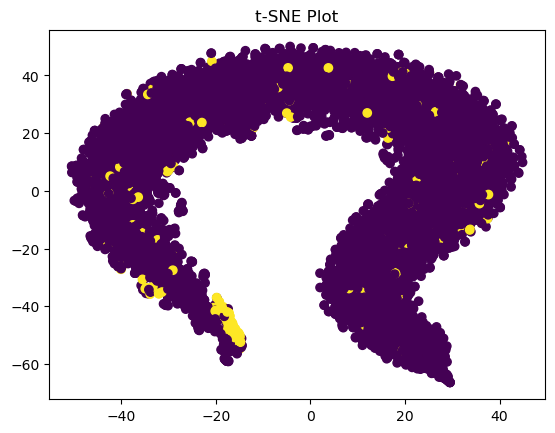

In [10]:
# Separate features and labels
X = df.drop('target', axis=1)
y = df['target']

# Initialize t-SNE object
tsne = TSNE(n_components=2, random_state=0)

# Fit and transform the data
X_tsne = tsne.fit_transform(X)

# Create the plot
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y)
plt.title('t-SNE Plot')
plt.show()

We can that the 2 classes (toxic and non toxic) are not properly separable, which might mean that this embedding is not necessarily the appropriate one for our dataset. Let's try to see how bad/good a baseline model will perform, and then try to improve performance wth more complex models.

## Baseline model

For this baseline model, we will implement an easy to go model, that is quite fast to run : Naive bayesian model !

But first, let's split ou dataset into train and test sets : 

In [21]:
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Size of the test set: {len(y_test)}")

Size of the test set: 1493


In [22]:
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.2, random_state=42, stratify=y_)

print(f"Size of the train set: {len(y_train)}")

Size of the train set: 4776


In [23]:
%%time 

baseline_model = GaussianNB()

baseline_model.fit(X_train, y_train)

CPU times: user 15.1 ms, sys: 11.2 ms, total: 26.3 ms
Wall time: 23.9 ms


GaussianNB()

In [24]:
y_pred = baseline_model.predict(X_val)

In [25]:
print(f"The accuracy on the validation set is {round(accuracy_score(y_val, y_pred),4)}")

The accuracy on the validation set is 0.7858


In [26]:
print(f"The f1-score on the validation set is {round(f1_score(y_val, y_pred),4)}")

The f1-score on the validation set is 0.195


In [27]:
print(f"The AUC score on the validation set is {round(roc_auc_score(y_val, y_pred),4)}")

The AUC score on the validation set is 0.7125


Here, we can notice the importance of the metric used to assess the performance of our model. Indeed, if we rely only on the accuracy and ROC AUC score, one can think that the model is not that bad. However, these two metrics are not adapted to unbalanced datasets, as it's the case for our datset. Conversely, the f-score metric is well suited for unbalanced datset, and reveal that the model is actually poorly performing. 

We will then focus on this metric for what follows !

## Random Forest 

### Model selection 

To select the hyperparameters of our RF, we will use cross validation, in order to avoid overfitting, and to get a better estimate of the performance of our model.

In [28]:
# SELECTION OF THE BEST PARAMETERS

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 10)]

max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 21, 32, 43, 54, 65, 76, 87, 98, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [29]:
%%time

rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_, y_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
CPU times: user 1min 1s, sys: 353 ms, total: 1min 2s
Wall time: 5min 45s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 21, 32, 43, 54, 65,
                                                      76, 87, 98, 110, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

[CV] END bootstrap=False, max_depth=98, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1600; total time= 1.9min
[CV] END bootstrap=False, max_depth=76, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  48.8s
[CV] END bootstrap=False, max_depth=76, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time= 1.4min
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  43.3s
[CV] END bootstrap=False, max_depth=76, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  47.7s
[CV] END bootstrap=False, max_depth=76, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time= 1.3min
[CV] END bootstrap=True, max_depth=76, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1200; total time=  53.3s
[CV] END bootstrap=True, max_dept

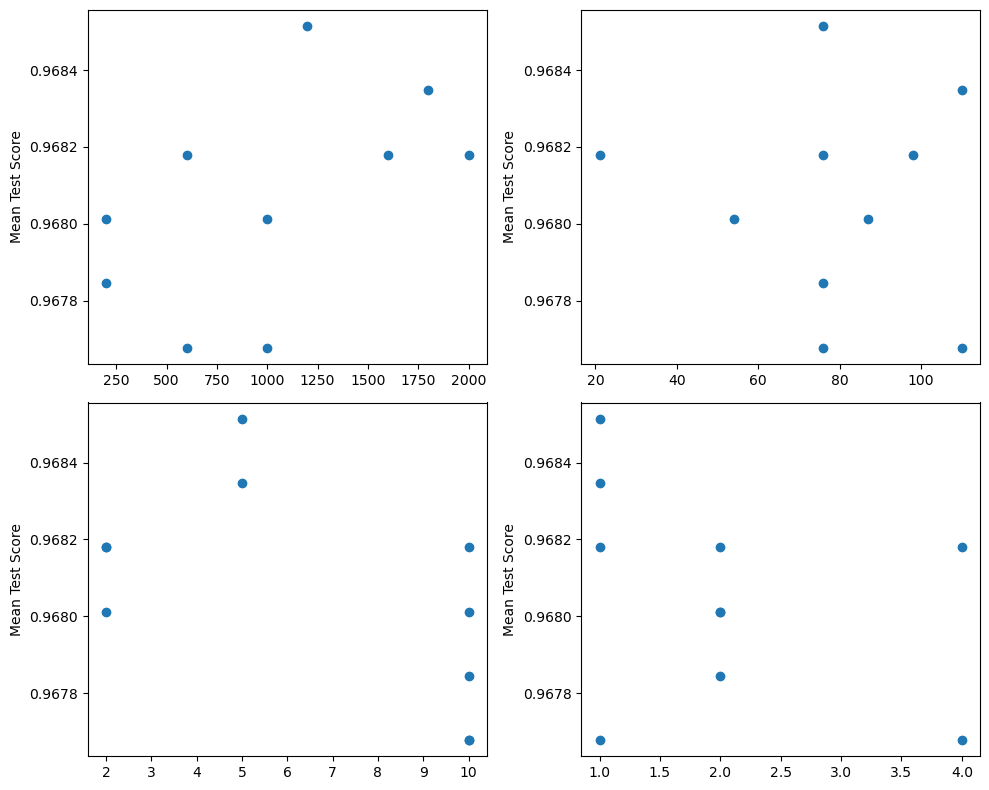

In [30]:
# Extract the mean test scores of the model for each parameter value
results = rf_random.cv_results_
n_estimators = results['param_n_estimators'].data
max_depth = results['param_max_depth'].data
min_samples_split = results['param_min_samples_split'].data
min_samples_leaf = results['param_min_samples_leaf'].data
max_features = results['param_max_features'].data
mean_test_score = results['mean_test_score']

# Plot the sensitivity of the model to each parameter
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
ax = ax.flatten()
for i, param in enumerate([n_estimators, max_depth, min_samples_split, min_samples_leaf]):
    ax[i].scatter(param, mean_test_score)
    #ax[i].set_xlabel(param.name)
    ax[i].set_ylabel('Mean Test Score')
plt.tight_layout()
plt.show()

In [31]:
rf_random.best_params_

{'n_estimators': 1200,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 76,
 'bootstrap': True}

In [34]:
RF = RandomForestClassifier(n_estimators=1200, min_samples_split=5, 
                            min_samples_leaf=1,max_features='auto',
                            max_depth=76, bootstrap=True)

In [35]:
RF.fit(X_train, y_train)

RandomForestClassifier(max_depth=76, min_samples_split=5, n_estimators=1200)

In [36]:
y_pred = RF.predict(X_val)

In [37]:
print(f"The f1-score on the validation set is {round(f1_score(y_val, y_pred),4)}")

The f1-score on the validation set is 0.4308
